<a href="https://colab.research.google.com/github/deding2000/COMP5329_Ass2/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Not needed before we upload files to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [74]:
from google.colab import files
uploaded = files.upload() # select all python files from the github page and kaggle.json

Saving Dataload.py to Dataload.py
Saving utils.py to utils.py


In [75]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'multi-label-classification-competition-2025'
! mkdir Dataset
! unzip multi-label-classification-competition-2025.zip -d Dataset &> /dev/null

mkdir: cannot create directory ‘/root/.kaggle’: File exists
User cancelled operation
mkdir: cannot create directory ‘Dataset’: File exists


Defining model arcitechture

In [98]:
# Model arcitechture
import torch.nn.functional as F
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()  # Compulsory operation.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=8, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32,64, 5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64,64,3, stride=1,padding=1)
        self.conv4 = nn.Conv2d(64,32,3, stride=1,padding=1)
        self.pool1 = nn.MaxPool2d(2,stride=2)
        self.pool2 = nn.MaxPool2d(3,stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm1d(150)
        self.bn6 = nn.BatchNorm1d(70)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout(0.5)
        self.dropout4 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(7200,150)
        self.fc2 = nn.Linear(150,70)
        self.fc3 = nn.Linear(70,18)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        #x = self.dropout1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        #x = self.dropout2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool1(F.relu(self.bn4(self.conv4(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout3(x)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout4(x)
        x = F.relu(self.bn6(self.fc2(x)))
        logits = self.fc3(x)
        return logits

Setup dataloaders and initialize model

In [101]:
import re
import pandas as pd
from io import StringIO
import os
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split, WeightedRandomSampler
from Dataload import pil_process_image_color, encode, Dataset, CustomImageDataset#, AddGaussianNoise
from utils import train_network, pos_weight, test
from metrics import compute_metrics
from sklearn.metrics import confusion_matrix
import torch
import numpy as np
from tqdm import tqdm

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return torch.clamp(tensor + noise, 0, 1)  # Ensure pixel values remain valid

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

# Hyperparameters
batch_size = 64
lr = 0.001 # 0.0005 before
weight_decay = 1e-4
INPUT_HEIGHT = 256
INPUT_WIDTH = 256

Normalize_weights = True
Use_weighted_loss = False

# Set device to GPU if this is available
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

# Loading filenames and labels
# Assumes data is in folder "Dataset"
DATASET_PATH = "/content/Dataset/COMP5329S1A2Dataset/"
FILENAME_TRAIN = 'train.csv'
FILENAME_TEST = 'test.csv'

with open(DATASET_PATH + FILENAME_TRAIN) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
with open(DATASET_PATH + FILENAME_TEST) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
df_train.to_csv("train_labels_captions.csv")
df_test.to_csv("test_labels_captions.csv")

# Defining transforms
resize = transforms.Resize(size=(INPUT_HEIGHT,
        INPUT_WIDTH)) # For resizing images to square

# Transform to use on common class
trainTransforms_basic = transforms.Compose(
    [resize,transforms.ToTensor()
    ,transforms.Normalize(mean=[0.3598, 0.3480, 0.3270], std=[0.1929, 0.1884, 0.1901])])
    #AddGaussianNoise(mean=0., std=0.1)])

# Data augmentation for uncommon class
trainTransforms_augment = transforms.Compose(
    [resize,transforms.RandomHorizontalFlip(),transforms.RandomAffine(degrees=30),
     transforms.ColorJitter(),transforms.RandomCrop(size=256,pad_if_needed=True),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.3598, 0.3480, 0.3270], std=[0.1929, 0.1884, 0.1901])])

# Transform for test images
testTransforms = transforms.Compose([resize,transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4652, 0.4492, 0.4214], std=[0.2317, 0.2265, 0.2303])])

# Sampling method
if Normalize_weights:
  # Calculate weights for loss function
  c_weights = pos_weight(df_train,barplot=False,normalize=True)
  samples_weight = torch.load("/content/norm_samples_weight_full.pt") # Sample common class less
else:
  c_weights = pos_weight(df_train,barplot=False,normalize=False)
  samples_weight = torch.load("/content/unnorm_samples_weight_full.pt") # Sample common class less

weighted_sampler_full = WeightedRandomSampler(samples_weight, len(samples_weight))

# Create dataloaders
training_data = CustomImageDataset(df_train,DATASET_PATH+"data/",transform=trainTransforms_basic,transform_aug=trainTransforms_augment,target_transform=encode)
test_data = CustomImageDataset(df_test,DATASET_PATH+"data/",transform=testTransforms,target_transform=None,targets_available=False)
train_dataloader = DataLoader(training_data, batch_size=batch_size, sampler=weighted_sampler_full) #Instead of shuffle = True
test_dataloader = DataLoader(test_data,shuffle=False)

# Setup model
model = CNN().to(device)

# Use BCE loss
if Use_weighted_loss:
  loss = torch.nn.BCEWithLogitsLoss(c_weights.to(device))
else:
  loss = torch.nn.BCEWithLogitsLoss()
# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
print('Model initialized.')

We are using GPU.
Class counts: tensor([22794.,  1162.,  4364.,  1272.,  1130.,  1394.,  1221.,  2210.,  1042.,
         1471.,   604.,   605.,   251.,  1934.,  1099.,  1430.,  1525.,  1020.],
       dtype=torch.float64)
Class weights: tensor([0.0110, 0.2160, 0.0575, 0.1973, 0.2221, 0.1801, 0.2056, 0.1136, 0.2409,
        0.1706, 0.4156, 0.4149, 1.0000, 0.1298, 0.2284, 0.1755, 0.1646, 0.2461],
       dtype=torch.float64)
Model initialized.


Training on subset of all data and compute metrics for validation set

  0%|          | 0/15 [00:00<?, ?it/s]


Train Epoch: 0 [0/23996 (0%)]	Loss: 0.705010

Train Epoch: 0 [3200/23996 (13%)]	Loss: 0.384574

Train Epoch: 0 [6400/23996 (27%)]	Loss: 0.320170

Train Epoch: 0 [9600/23996 (40%)]	Loss: 0.303111

Train Epoch: 0 [12800/23996 (53%)]	Loss: 0.348172

Train Epoch: 0 [16000/23996 (67%)]	Loss: 0.281090

Train Epoch: 0 [19200/23996 (80%)]	Loss: 0.292275

Train Epoch: 0 [22400/23996 (93%)]	Loss: 0.275334


  7%|▋         | 1/15 [01:48<25:25, 108.94s/it]


Test set results: Average loss: 0.2152, F1 Score: 0.62

Train Epoch: 1 [0/23996 (0%)]	Loss: 0.302052

Train Epoch: 1 [3200/23996 (13%)]	Loss: 0.309038

Train Epoch: 1 [6400/23996 (27%)]	Loss: 0.301778

Train Epoch: 1 [9600/23996 (40%)]	Loss: 0.275997

Train Epoch: 1 [12800/23996 (53%)]	Loss: 0.260700

Train Epoch: 1 [16000/23996 (67%)]	Loss: 0.270308

Train Epoch: 1 [19200/23996 (80%)]	Loss: 0.259933

Train Epoch: 1 [22400/23996 (93%)]	Loss: 0.263752


 13%|█▎        | 2/15 [03:38<23:37, 109.02s/it]


Test set results: Average loss: 0.1819, F1 Score: 0.65

Train Epoch: 2 [0/23996 (0%)]	Loss: 0.276246

Train Epoch: 2 [3200/23996 (13%)]	Loss: 0.253666

Train Epoch: 2 [6400/23996 (27%)]	Loss: 0.274232

Train Epoch: 2 [9600/23996 (40%)]	Loss: 0.273323

Train Epoch: 2 [12800/23996 (53%)]	Loss: 0.252036

Train Epoch: 2 [16000/23996 (67%)]	Loss: 0.242625

Train Epoch: 2 [19200/23996 (80%)]	Loss: 0.280684

Train Epoch: 2 [22400/23996 (93%)]	Loss: 0.266612


 20%|██        | 3/15 [05:26<21:45, 108.81s/it]


Test set results: Average loss: 0.1664, F1 Score: 0.66

Train Epoch: 3 [0/23996 (0%)]	Loss: 0.269185

Train Epoch: 3 [3200/23996 (13%)]	Loss: 0.266447

Train Epoch: 3 [6400/23996 (27%)]	Loss: 0.246714

Train Epoch: 3 [9600/23996 (40%)]	Loss: 0.265294

Train Epoch: 3 [12800/23996 (53%)]	Loss: 0.255648

Train Epoch: 3 [16000/23996 (67%)]	Loss: 0.243037

Train Epoch: 3 [19200/23996 (80%)]	Loss: 0.242993

Train Epoch: 3 [22400/23996 (93%)]	Loss: 0.250535


 27%|██▋       | 4/15 [07:15<19:56, 108.79s/it]


Test set results: Average loss: 0.1708, F1 Score: 0.65

Train Epoch: 4 [0/23996 (0%)]	Loss: 0.231324

Train Epoch: 4 [3200/23996 (13%)]	Loss: 0.239334

Train Epoch: 4 [6400/23996 (27%)]	Loss: 0.226956

Train Epoch: 4 [9600/23996 (40%)]	Loss: 0.255902

Train Epoch: 4 [12800/23996 (53%)]	Loss: 0.231915

Train Epoch: 4 [16000/23996 (67%)]	Loss: 0.265802

Train Epoch: 4 [19200/23996 (80%)]	Loss: 0.223297

Train Epoch: 4 [22400/23996 (93%)]	Loss: 0.255077


 33%|███▎      | 5/15 [09:03<18:07, 108.72s/it]


Test set results: Average loss: 0.1633, F1 Score: 0.67

Train Epoch: 5 [0/23996 (0%)]	Loss: 0.235513

Train Epoch: 5 [3200/23996 (13%)]	Loss: 0.227691

Train Epoch: 5 [6400/23996 (27%)]	Loss: 0.228803

Train Epoch: 5 [9600/23996 (40%)]	Loss: 0.225019

Train Epoch: 5 [12800/23996 (53%)]	Loss: 0.272203

Train Epoch: 5 [16000/23996 (67%)]	Loss: 0.253026

Train Epoch: 5 [19200/23996 (80%)]	Loss: 0.241308

Train Epoch: 5 [22400/23996 (93%)]	Loss: 0.235812


 40%|████      | 6/15 [10:52<16:17, 108.66s/it]


Test set results: Average loss: 0.1618, F1 Score: 0.67

Train Epoch: 6 [0/23996 (0%)]	Loss: 0.246145

Train Epoch: 6 [3200/23996 (13%)]	Loss: 0.239926

Train Epoch: 6 [6400/23996 (27%)]	Loss: 0.250257

Train Epoch: 6 [9600/23996 (40%)]	Loss: 0.204126

Train Epoch: 6 [12800/23996 (53%)]	Loss: 0.233582

Train Epoch: 6 [16000/23996 (67%)]	Loss: 0.223809

Train Epoch: 6 [19200/23996 (80%)]	Loss: 0.234210

Train Epoch: 6 [22400/23996 (93%)]	Loss: 0.251401


 47%|████▋     | 7/15 [12:41<14:30, 108.78s/it]


Test set results: Average loss: 0.1714, F1 Score: 0.66

Train Epoch: 7 [0/23996 (0%)]	Loss: 0.226820

Train Epoch: 7 [3200/23996 (13%)]	Loss: 0.227735

Train Epoch: 7 [6400/23996 (27%)]	Loss: 0.235523

Train Epoch: 7 [9600/23996 (40%)]	Loss: 0.216645

Train Epoch: 7 [12800/23996 (53%)]	Loss: 0.225650

Train Epoch: 7 [16000/23996 (67%)]	Loss: 0.205425

Train Epoch: 7 [19200/23996 (80%)]	Loss: 0.239087

Train Epoch: 7 [22400/23996 (93%)]	Loss: 0.219459


 53%|█████▎    | 8/15 [14:30<12:42, 108.91s/it]


Test set results: Average loss: 0.1658, F1 Score: 0.66

Train Epoch: 8 [0/23996 (0%)]	Loss: 0.221149

Train Epoch: 8 [3200/23996 (13%)]	Loss: 0.221051

Train Epoch: 8 [6400/23996 (27%)]	Loss: 0.266757

Train Epoch: 8 [9600/23996 (40%)]	Loss: 0.203741

Train Epoch: 8 [12800/23996 (53%)]	Loss: 0.218589

Train Epoch: 8 [16000/23996 (67%)]	Loss: 0.231485

Train Epoch: 8 [19200/23996 (80%)]	Loss: 0.245437

Train Epoch: 8 [22400/23996 (93%)]	Loss: 0.226956


 60%|██████    | 9/15 [16:19<10:53, 108.98s/it]


Test set results: Average loss: 0.1610, F1 Score: 0.68

Train Epoch: 9 [0/23996 (0%)]	Loss: 0.249312

Train Epoch: 9 [3200/23996 (13%)]	Loss: 0.237572

Train Epoch: 9 [6400/23996 (27%)]	Loss: 0.205363

Train Epoch: 9 [9600/23996 (40%)]	Loss: 0.237741

Train Epoch: 9 [12800/23996 (53%)]	Loss: 0.208207

Train Epoch: 9 [16000/23996 (67%)]	Loss: 0.211370

Train Epoch: 9 [19200/23996 (80%)]	Loss: 0.206489

Train Epoch: 9 [22400/23996 (93%)]	Loss: 0.218116


 67%|██████▋   | 10/15 [18:09<09:05, 109.09s/it]


Test set results: Average loss: 0.1570, F1 Score: 0.68

Train Epoch: 10 [0/23996 (0%)]	Loss: 0.202690

Train Epoch: 10 [3200/23996 (13%)]	Loss: 0.219795

Train Epoch: 10 [6400/23996 (27%)]	Loss: 0.224493

Train Epoch: 10 [9600/23996 (40%)]	Loss: 0.208962

Train Epoch: 10 [12800/23996 (53%)]	Loss: 0.206542

Train Epoch: 10 [16000/23996 (67%)]	Loss: 0.209324

Train Epoch: 10 [19200/23996 (80%)]	Loss: 0.210637

Train Epoch: 10 [22400/23996 (93%)]	Loss: 0.204571


 73%|███████▎  | 11/15 [19:57<07:15, 108.97s/it]


Test set results: Average loss: 0.1585, F1 Score: 0.67

Train Epoch: 11 [0/23996 (0%)]	Loss: 0.206593

Train Epoch: 11 [3200/23996 (13%)]	Loss: 0.236940

Train Epoch: 11 [6400/23996 (27%)]	Loss: 0.223712

Train Epoch: 11 [9600/23996 (40%)]	Loss: 0.192754

Train Epoch: 11 [12800/23996 (53%)]	Loss: 0.183744

Train Epoch: 11 [16000/23996 (67%)]	Loss: 0.215536

Train Epoch: 11 [19200/23996 (80%)]	Loss: 0.195838

Train Epoch: 11 [22400/23996 (93%)]	Loss: 0.221800


 80%|████████  | 12/15 [21:46<05:26, 108.74s/it]


Test set results: Average loss: 0.1608, F1 Score: 0.67

Train Epoch: 12 [0/23996 (0%)]	Loss: 0.235013

Train Epoch: 12 [3200/23996 (13%)]	Loss: 0.234543

Train Epoch: 12 [6400/23996 (27%)]	Loss: 0.209139

Train Epoch: 12 [9600/23996 (40%)]	Loss: 0.226155

Train Epoch: 12 [12800/23996 (53%)]	Loss: 0.191876

Train Epoch: 12 [16000/23996 (67%)]	Loss: 0.232755

Train Epoch: 12 [19200/23996 (80%)]	Loss: 0.206277

Train Epoch: 12 [22400/23996 (93%)]	Loss: 0.182444


 87%|████████▋ | 13/15 [23:35<03:37, 108.91s/it]


Test set results: Average loss: 0.1550, F1 Score: 0.68

Train Epoch: 13 [0/23996 (0%)]	Loss: 0.203258

Train Epoch: 13 [3200/23996 (13%)]	Loss: 0.224845

Train Epoch: 13 [6400/23996 (27%)]	Loss: 0.180935

Train Epoch: 13 [9600/23996 (40%)]	Loss: 0.201057

Train Epoch: 13 [12800/23996 (53%)]	Loss: 0.190569

Train Epoch: 13 [16000/23996 (67%)]	Loss: 0.201739

Train Epoch: 13 [19200/23996 (80%)]	Loss: 0.203182

Train Epoch: 13 [22400/23996 (93%)]	Loss: 0.193023


 93%|█████████▎| 14/15 [25:24<01:48, 108.93s/it]


Test set results: Average loss: 0.1544, F1 Score: 0.67

Train Epoch: 14 [0/23996 (0%)]	Loss: 0.204844

Train Epoch: 14 [3200/23996 (13%)]	Loss: 0.224235

Train Epoch: 14 [6400/23996 (27%)]	Loss: 0.199415

Train Epoch: 14 [9600/23996 (40%)]	Loss: 0.187747

Train Epoch: 14 [12800/23996 (53%)]	Loss: 0.222071

Train Epoch: 14 [16000/23996 (67%)]	Loss: 0.209849

Train Epoch: 14 [19200/23996 (80%)]	Loss: 0.189039

Train Epoch: 14 [22400/23996 (93%)]	Loss: 0.190813


100%|██████████| 15/15 [27:14<00:00, 108.99s/it]


Test set results: Average loss: 0.1545, F1 Score: 0.68


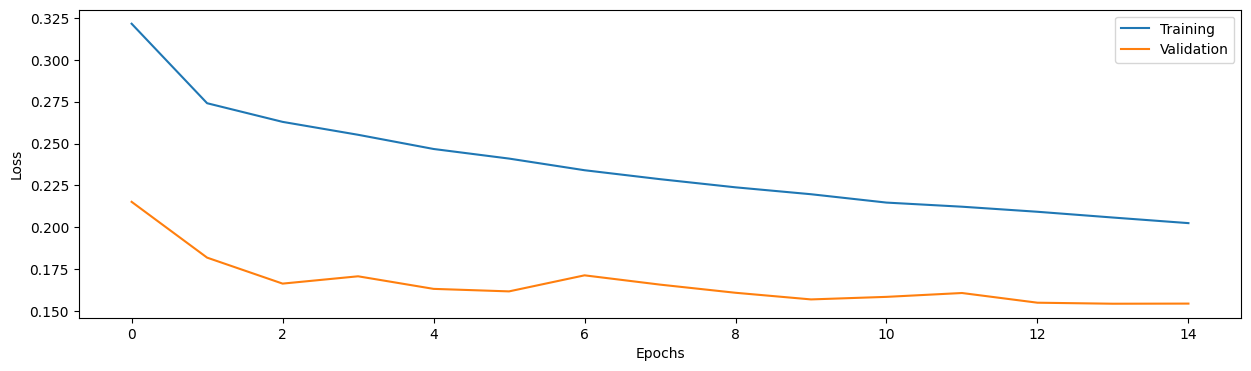

With prediction_all = True:

Test set results: Average loss: 0.1545, F1 Score: 0.68
Full Metrics
{'F1_score': 0.683844181218708, 'accuracy': 0.9520555555555555, 'precision': 0.7829977628635347, 'recall': 0.6069802731411229}
With prediction_all = False:

Test set results: Average loss: 0.1544, F1 Score: 0.68
Full Metrics
{'F1_score': 0.6842343800582712, 'accuracy': 0.9548425925925926, 'precision': 0.8496542852548641, 'recall': 0.5727292434424452}


In [102]:
# Loading indices for 80/20 split of training data
train_idx = np.load("/content/subset_train_indices.npy")
validation_idx = np.load("/content/validation_indices.npy")
# Loading sample weights to sample some classes more than others

if Normalize_weights:
  samples_weight_subset = torch.load("/content/norm_samples_weight_subset.pt")
else:
  samples_weight_subset = torch.load("/content/unnorm_samples_weight_subset.pt") # Sample common class less

weigthed_sampler_subset = WeightedRandomSampler(samples_weight_subset,len(samples_weight_subset))

# Subset dataset for train and val
subset_train_dataset = Subset(training_data, train_idx)
validation_dataset = Subset(training_data, validation_idx)
subset_train_loader = DataLoader(subset_train_dataset, batch_size=batch_size,sampler=weigthed_sampler_subset) #shuffle=True)
validation_loader = DataLoader(validation_dataset, shuffle=False)

# Training
log_interval = 50 # How often we print train loss
train_losses, test_losses = train_network(log_interval,model, device, subset_train_loader, validation_loader,optimizer, loss,epochs=15)

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.plot(test_losses,label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.show()

# Set thresholds for predictions
thresholds = [0.5]*18

# Testing on validation set and compute metrics
print("With prediction_all = True:")
test_loss, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True,predict_all=True) # output predictions as tensors
all_preds = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_preds])
all_targets = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_targets])
#for label in range(1,19): # remember that 12 is deleted!
#   print("Metrics for class {}".format(label))
#   print(compute_metrics(all_preds.squeeze()[:,label-1],all_targets.squeeze()[:,label-1]))
print("Full Metrics")
print(compute_metrics(all_preds,all_targets))

print("With prediction_all = False:")
test_loss, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True,predict_all=False) # output predictions as tensors
all_preds = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_preds])
all_targets = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_targets])
print("Full Metrics")
print(compute_metrics(all_preds,all_targets))

In [90]:
print("Prediction on training set with prediction_all = True:")
test_loss, all_preds, all_targets = test(model, device, subset_train_loader, loss, thresholds=thresholds, target_available=True,predict_all=False) # output predictions as tensors
all_preds = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_preds])
all_targets = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_targets])
#for label in range(1,19): # remember that 12 is deleted!
#   print("Metrics for class {}".format(label))
#   print(compute_metrics(all_preds.squeeze()[:,label-1],all_targets.squeeze()[:,label-1]))

Prediction on training set with prediction_all = True:

Test set results: Average loss: 0.0786, F1 Score: 0.89


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (94,) + inhomogeneous part.

Tuning of thresholds

In [ ]:
threshold_values = [0.55,0.5,0.45,0.4,0.35,0.3]
thresholds = [0.5]*18
best_thresholds = []
for label in range(1,19): # remember that class 12 is deleted!
    print("Searching for label {}".format(label))
    best_F1 = 0
    for idx in tqdm(range(len(threshold_values))):
        thresholds[label-1] = threshold_values[idx]
        _, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True) # output predictions as tensors
        all_preds = np.asarray([pred.cpu() for pred in all_preds])
        all_targets = np.asarray([targ.cpu() for targ in all_targets])
        F1_score = compute_metrics(all_preds,all_targets)["F1_score"]
        if F1_score > best_F1:
            best_F1 = F1_score
            best_threshold = threshold_values[idx]
            best_thresholds.append(best_threshold)
    print("Found best F1: {}".format(best_F1))
    print("Found best threshold {}".format(best_threshold))
    thresholds[label-1] = best_threshold
print("Final Thresholds = {}".format(thresholds))

Searching for label 2
Found best F1: 0.663791884631698
Found best threshold 0.35
Searching for label 3
Found best F1: 0.6667128987517337
Found best threshold 0.3
Searching for label 4
Found best F1: 0.6674057649667406
Found best threshold 0.4
Searching for label 5
Found best F1: 0.6662981898576759
Found best threshold 0.45
Searching for label 6
Found best F1: 0.6675383662514623
Found best threshold 0.3
Searching for label 7
Found best F1: 0.667125740256163
Found best threshold 0.5
Searching for label 8
Found best F1: 0.6689636163175302
Found best threshold 0.4
Searching for label 9
Found best F1: 0.6685509444367848
Found best threshold 0.3
Searching for label 10
Found best F1: 0.6677197802197802
Found best threshold 0.35
Searching for label 11
Found best F1: 0.6664835542127308
Found best threshold 0.4
Searching for label 12
Found best F1: 0.6675839295542102
Found best threshold 0.4
Searching for label 13
Found best F1: 0.6680423717155042
Found best threshold 0.4
Searching for label 14


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-71-bcc6e729e3f2>", line 10, in <cell line: 0>
    _, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True) # output predictions as tensors
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-62-e17ac7eb4db6>", line 20, in test
    for data, target in (test_loader):  # Iterate through the entire test set.
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 708, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 764, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may r

Check model size and save temporary model

Model saved to /content/model_test.pt
Model size: 4.615449905395508 MB


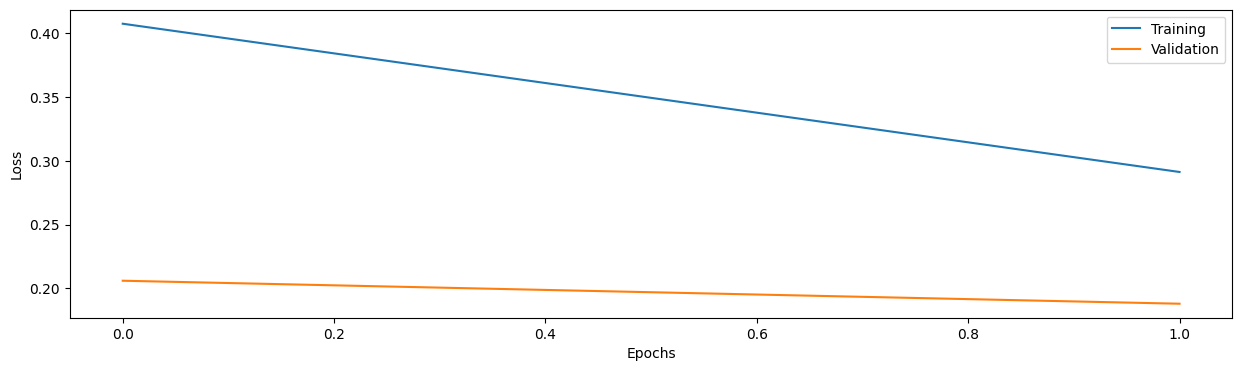

In [82]:
# save model, scores and plot and check size of model is under 100MB
model_name = "test"

path_name_model = "/content/model_" + model_name+".pt"
path_name_plot = "/content/model_" + model_name + "_losscurve.png"
path_name_scores = "/content/model_" + model_name + "_scores.txt"

torch.save(model.state_dict(), path_name_model)
print(f"Model saved to {path_name_model}")
size_mb = os.path.getsize(path_name_model) / (1024 * 1024)
print(f"Model size: {size_mb} MB")

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.plot(test_losses,label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.savefig(path_name_plot)

import json
with open(path_name_scores, 'w') as file:
     file.write(json.dumps(compute_metrics(all_preds,all_targets)))

Train model on entire training set and compute predictions

In [83]:
# Training new model on the full dataset
model_full = CNN().to(device)
c_weights_full = c_weights.to(device)
loss_full = torch.nn.BCEWithLogitsLoss() #c_weights_full)
optimizer_full = torch.optim.Adam(model_full.parameters(), lr=lr)
print('Full Model initialized.')
log_interval = 50 # How often we print train loss
train_losses_full = train_network(log_interval,model_full, device, train_dataloader, test_loader=0,optimizer=optimizer_full, loss=loss_full,epochs=30)

plt.figure(figsize=(15,4))
plt.plot(train_losses_full,label="Training")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')

# Compute predictions for true test set
thresholds_full = [0.5]*18
test_pred_full = test(model_full, device, test_dataloader,loss_full,thresholds=thresholds_full,target_available=False,predict_all=True)
test_pred_full_predict_all_false = test(model_full, device, test_dataloader,loss_full,thresholds=thresholds_full,target_available=False,predict_all=False)

Full Model initialized.


  0%|          | 0/30 [00:00<?, ?it/s]


Train Epoch: 0 [0/29996 (0%)]	Loss: 0.761133

Train Epoch: 0 [12800/29996 (53%)]	Loss: 0.314905


  3%|▎         | 1/30 [01:20<38:57, 80.61s/it]


Train Epoch: 1 [0/29996 (0%)]	Loss: 0.197992


  3%|▎         | 1/30 [01:51<53:48, 111.33s/it]


KeyboardInterrupt: 

In [84]:
# Compute predictions for true test set
thresholds_full = [0.5]*18
test_pred_full = test(model_full, device, test_dataloader,loss_full,thresholds=thresholds_full,target_available=False,predict_all=True)
test_pred_full_predict_all_false = test(model_full, device, test_dataloader,loss_full,thresholds=thresholds_full,target_available=False,predict_all=False)

100%|██████████| 10000/10000 [00:45<00:00, 221.22it/s]



Predictions computed for test set.


100%|██████████| 10000/10000 [00:45<00:00, 221.08it/s]


Predictions computed for test set.


Save full model, check size and get predictions

Full Model saved to /content/model_24_05_25_two_hidden_full.pt
Full Model size: 3.243013381958008 MB
Submission dataframe:
<bound method NDFrame.describe of         ImageID Labels
0     30000.jpg      1
1     30001.jpg      1
2     30002.jpg      1
3     30003.jpg      1
4     30004.jpg      1
...         ...    ...
9995  39995.jpg      1
9996  39996.jpg  1 3 4
9997  39997.jpg      1
9998  39998.jpg      1
9999  39999.jpg      1

[10000 rows x 2 columns]>
Predictions saved as /content/submission_pred_all_false.csv


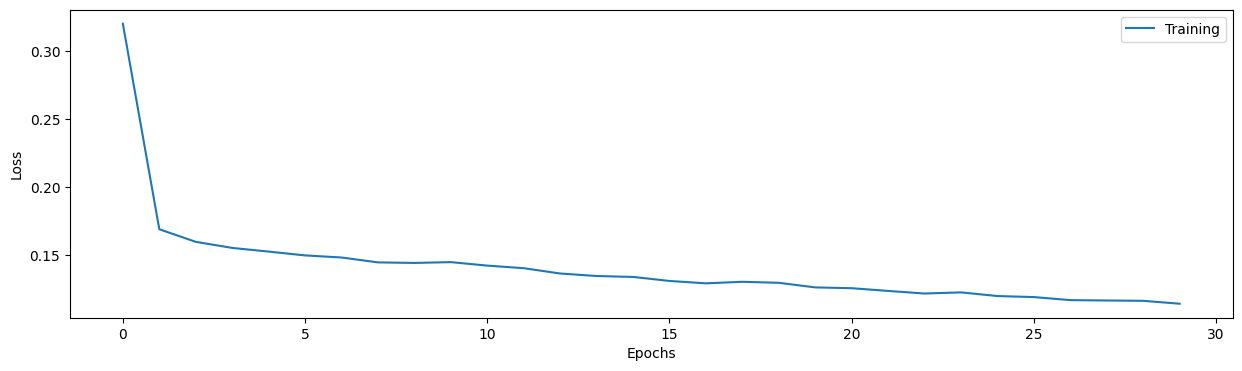

In [ ]:
# Convert predictions to csv
from tqdm import tqdm
import numpy as np

#test_pred_full = test(model_full, device, test_dataloader,loss,thresholds=thresholds_full,target_available=False)
#print(test_pred_full)

def get_class(array):
  class_pred = np.where(array > 0.5)[1] + 1
  for i in range(len(class_pred)):
    if class_pred[i] >= 12:
      class_pred += 1
  return class_pred

def unencode(y_pred,to_cpu=True):
  labels = []
  for i in range(len(y_pred)):
    if to_cpu: # Move to cpu device
      temp = y_pred[i].cpu()
    temp = np.asarray(temp)
    temp = get_class(temp)
    temp = " ".join(str(item) for item in temp)
    labels.append(temp)
  return labels

# Save full model
path_name_model = "/content/model_" + model_name + "_full.pt"
path_name_plot = "/content/model_" + model_name + "_losscurve_full.png"

torch.save(model_full.state_dict(), path_name_model)
print(f"Full Model saved to {path_name_model}")
size_mb = os.path.getsize(path_name_model) / (1024 * 1024)
print(f"Full Model size: {size_mb} MB")

plt.figure(figsize=(15,4))
plt.plot(train_losses_full,label="Training")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.savefig(path_name_plot)

#Save predictions in csv
pred_labels = unencode(test_pred_full_predict_all_false)
pred_df = df_test.copy()
pred_df = pred_df.drop("Caption",axis=1)
pred_df["Labels"] = pred_labels
print("Submission dataframe:")
print(pred_df.describe)
submission_name = "/content/submission.csv"
pred_df.to_csv(submission_name,index=False)
print(f"Predictions saved as {submission_name}")

In [ ]:
# Submit predictions
! kaggle competitions submit -c multi-label-classification-competition-2025 -f /content/submission.csv -m "More complex CNN without pred all"

100% 120k/120k [00:00<00:00, 125kB/s]
Successfully submitted to Multi-label Classification Competition 2025